<a href="https://colab.research.google.com/github/cjkreienkamp/wpolo-scoresheet-ocr/blob/main/gamelog_classfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Configure Environment

**Note**: If you are running this in Colab, enable a GPU

> `Runtime`   →   `Change runtime type`   →   `Hardware Accelerator: GPU`

### 0.1 Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
from PIL import Image

### 0.2 Configure GPU

In [2]:
print(torch.__version__)   # this notebook requires torch >= 1.10.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.3.1+cu121


'cuda'

## 1. Collect Data

### 1.0 Functions

In [ ]:
def rotate(x):
  x_rotated = []
  for i in range(x.shape[0]):
    img = Image.fromarray(x[i])
    img = img.rotate(90)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    x_rotated.append(np.array(img))
  x_rotated = np.array(x_rotated)
  return x_rotated

### 1.1 Pull the data from an online repository

In [4]:
dataset = torchvision.datasets.MNIST(root='data', train=True, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14089697.82it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 445168.51it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4293840.51it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2933106.82it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### 1.2 Visualize the data

image shape: torch.Size([60000, 28, 28])
label shape: torch.Size([60000])
classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


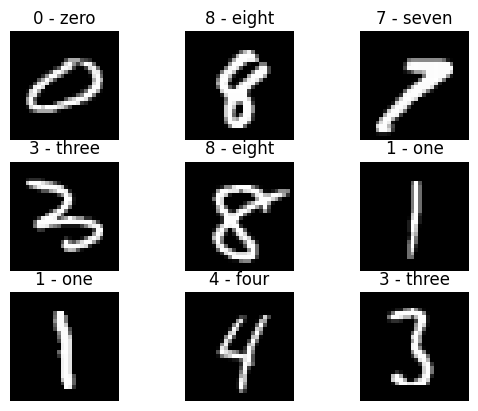

In [5]:
classes = dataset.classes
NUM_CLASSES = len(classes)

print('image shape:',dataset.data.shape)
print('label shape:',dataset.targets.shape)
print('classes:',classes)

random_sample = np.random.randint(0, dataset.data.shape[0], 9)
for i , sample in zip(range(9), random_sample):
  image, label = dataset[sample]
  plt.subplot(3, 3, i + 1)
  plt.imshow(image, cmap="gray")
  plt.title(classes[label])
  plt.axis("off")
plt.show()

## 2. Prepare Data

### 2.1 Convert data to tensors and resize

In [6]:
transform=torchvision.transforms.Compose([transforms.ToTensor()])
dataset_tensor = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
val_tensor = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
print('tensor shape:',dataset_tensor.data.shape)

tensor shape: torch.Size([60000, 28, 28])


### 2.2 Split the dataset into train, test, and validation

* training set - used to train the model, compute the loss, and adjust the weights of the model using gradient descent

* test set - used to evaluate the training model, adjust the hyperparameters, and pick the best version of the model

* validation set - used as a final check of model predictions on new data to evaluate model performance

In [7]:
train_tensor, test_tensor = random_split(dataset_tensor, [0.8, 0.2])

print('samples in train dataset: ', len(train_tensor))
print('samples in test dataset: ', len(test_tensor))
print('samples in validation dataset: ', len(val_tensor))

samples in train dataset:  48000
samples in test dataset:  12000
samples in validation dataset:  10000


### 2.3 Convert to dataloaders

In [9]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(train_tensor, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_tensor, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle = False)

img_custom, label_custom = next(iter(train_dataloader))
print(f"Dataloader image shape: {img_custom.shape} --> [batch_size, color_channels, height, width]")
print(f"Dataloader label shape: {label_custom.shape}")

DATALOADER_COLOR_CHANNELS = img_custom.shape[1]
DATALOADER_HEIGHT = img_custom.shape[2]
DATALOADER_WIDTH = img_custom.shape[3]

Creating DataLoader's with batch size 128 and 2 workers.
Dataloader image shape: torch.Size([128, 1, 28, 28]) --> [batch_size, color_channels, height, width]
Dataloader label shape: torch.Size([128])


## 3. Train Model

### 3.1 Build model

In [10]:
class EmnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(inplace=True)) #32*28*28
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(2)) #64*14*14
        self.res1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True)) #64*14*14
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True)) #128*14*14
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(2)) #256*7*7
        self.res2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True)) #256*7*7
        self.classifier = nn.Sequential(nn.Flatten(),
                          nn.Linear(256*7*7, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 256),
                          nn.ReLU(),
                          nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = torch.flatten(out, start_dim=1)
        out = self.classifier(out)
        return out

    def training_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label]).to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label]).to(device)
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        return {'val_loss': loss, 'val_acc': accuracy}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['train_loss'], result['val_acc']))

model = EmnistModel()
model

EmnistModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Se

### 3.2 Create train & test loop functions

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y); train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [12]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y); test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [13]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### 3.3 Train model

In [14]:
model_0 = EmnistModel().to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
NUM_EPOCHS = 5

from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:18<01:12, 18.23s/it]

Epoch: 1 | train_loss: 0.2617 | train_acc: 0.9303 | test_loss: 0.1014 | test_acc: 0.9678


 40%|████      | 2/5 [00:34<00:51, 17.12s/it]

Epoch: 2 | train_loss: 0.0497 | train_acc: 0.9850 | test_loss: 0.0545 | test_acc: 0.9824


 60%|██████    | 3/5 [00:50<00:33, 16.76s/it]

Epoch: 3 | train_loss: 0.0350 | train_acc: 0.9888 | test_loss: 0.0392 | test_acc: 0.9889


 80%|████████  | 4/5 [01:06<00:16, 16.43s/it]

Epoch: 4 | train_loss: 0.0289 | train_acc: 0.9914 | test_loss: 0.0459 | test_acc: 0.9868


100%|██████████| 5/5 [01:22<00:00, 16.57s/it]

Epoch: 5 | train_loss: 0.0255 | train_acc: 0.9917 | test_loss: 0.0523 | test_acc: 0.9848
Total training time: 82.870 seconds


## 4. Evaluate Model

### 4.0 Functions

In [15]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.xlabel('Epochs')
    plt.legend()

### 4.1 Plot loss and accuracy curves

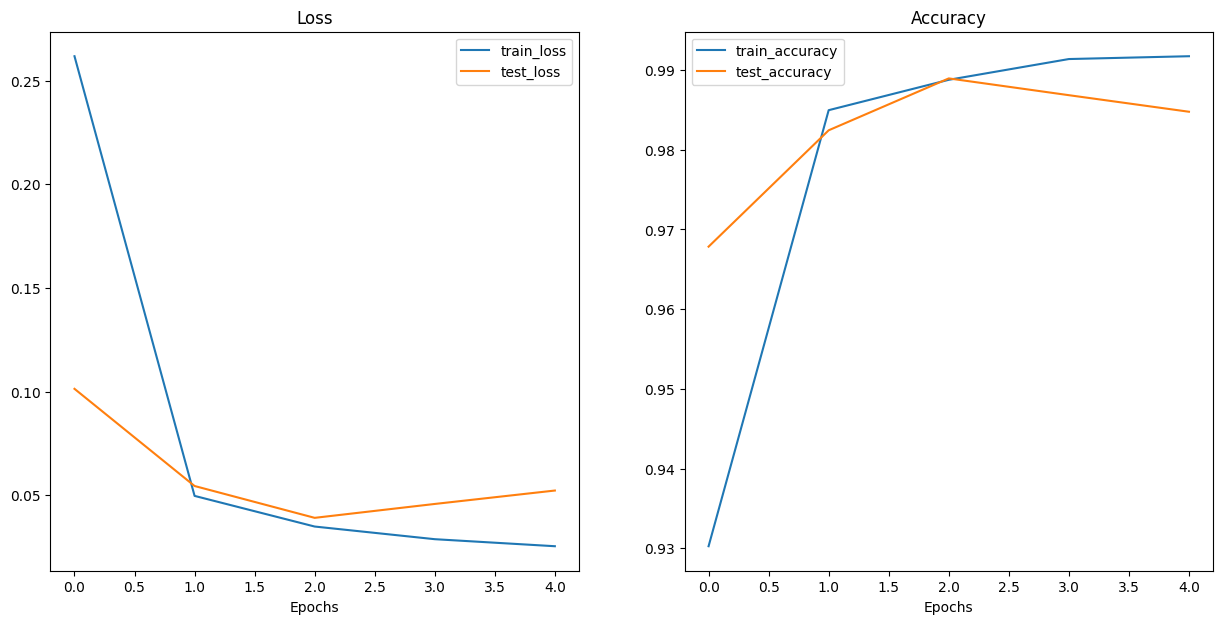

In [16]:
plot_loss_curves(model_0_results)

## 5. Predict

### 5.0 Functions

In [19]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0) # add an extra dimension to image
        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1) # convert logits --> prediction probabilities
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1) # convert prediction probabilities --> prediction labels

    plt.imshow(target_image.squeeze(), cmap='gray')
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

### 5.1 Save model

In [20]:
emnist_model = torch.jit.script(model_0)
emnist_model.save('gamelog_model.pt')

### 5.2 Predict and plot custom image

test.jpg


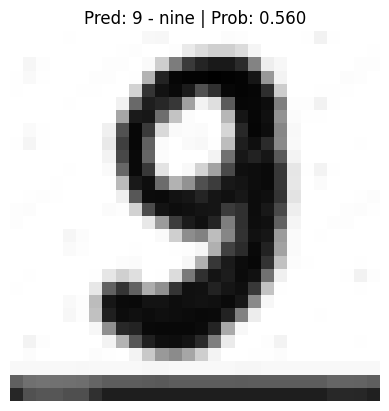

In [23]:
import torchvision
import pathlib

custom_image_path = 'test.jpg'
print(custom_image_path)
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image / 255.

custom_image_transform = transforms.Compose([
    transforms.Lambda((lambda x: x[:3])),
    transforms.Resize((DATALOADER_HEIGHT, DATALOADER_WIDTH)),
    transforms.Grayscale(num_output_channels=1)
])

classes = dataset.classes
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=classes,
                    transform=custom_image_transform,
                    device=device)

### 5.10 Appendix

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")